# This Jupyter Notebook is there to deliver the weekly tweets for CamelQuant

### Loading in libraries and datasets 

In [15]:
# Loading in libraries
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans

# # # # LOADING IN DATA # # # #
#     -------------------
# 1. BTC Dataset
btc_stats = pd.read_csv('bitcoin_all.csv', delimiter=';')
columns_to_convert = ['timeOpen', 'timeClose', 'timeHigh', 'timeLow', 'timestamp']
btc_stats[columns_to_convert] = btc_stats[columns_to_convert].apply(lambda col: pd.to_datetime(col, utc=True))
btc_stats = btc_stats.sort_values('timestamp').reset_index(drop=True)
btc_stats = btc_stats.drop('name', axis=1)

# 2. Google Trends
gtrends = pd.read_csv('gtrends.csv', header=1)
gtrends.Day = pd.to_datetime(gtrends.Day, utc=True)
gtrends.rename(columns={'bitcoin: (Worldwide)': 'GTrends'}, inplace=True)

# 3. Reddit Sentiment Analysis
reddit = pd.read_csv('reddit_sentiment.csv')
reddit.date_posted = pd.to_datetime(reddit.date_posted, utc=True)

# 4. Merging the dataframes 
btc_all = pd.merge(btc_stats, gtrends, left_on='timeOpen', right_on='Day', how='left')
btc_all = pd.merge(btc_all, reddit, left_on='timeOpen', right_on='date_posted', how='left')
btc_all = btc_all[['timeOpen', 'open', 'high', 'low', 'close', 'volume', 'marketCap', 'GTrends', 'weighted_sen']]

#### Add Technical Indicators to the Dataframe

In [45]:

# 1. Bollinger Bands
def bollinger_bands(df, window=20, num_std=2):
    # Calculate the moving average and standard deviation
    df['MA'] = df['close'].rolling(window=window).mean()
    df['STD'] = df['close'].rolling(window=window).std()
    
    # Calculate upper and lower Bollinger Bands
    df['Upper'] = df['MA'] + (df['STD'] * num_std)
    df['Lower'] = df['MA'] - (df['STD'] * num_std)
    
    # Calculate Bollinger Bands trend determination
    df['bollinger_bands_td'] = np.nan
    df.loc[df['close'] > df['Upper'], 'bollinger_bands_td'] = 0  # Sell signal
    df.loc[df['close'] < df['Lower'], 'bollinger_bands_td'] = 1  # Buy signal
    
    # Forward fill the signals
    df['bollinger_bands_td'] = df['bollinger_bands_td'].ffill()
    
    return df
btc_all = bollinger_bands(btc_all)

# 2. MACD
def macd(df, short=12, long=26, signal=9):
    # Calculate the MACD and MACD Signal
    df['MACD'] = df['close'].ewm(span=short).mean() - df['close'].ewm(span=long).mean()
    df['MACD_Signal'] = df['MACD'].ewm(span=signal).mean()
    
    # Calculate MACD trend determination
    df['macd_td'] = np.nan
    df.loc[df['MACD'] > df['MACD_Signal'], 'macd_td'] = 0  # Sell signal
    df.loc[df['MACD'] < df['MACD_Signal'], 'macd_td'] = 1  # Buy signal
    
    # Forward fill the signals
    df['macd_td'] = df['macd_td'].ffill()
    
    return df
btc_all = macd(btc_all)

# 3. RSI
def rsi(df, window=14):
    delta = df['close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    df['RSI'] = 100 - (100 / (1 + rs))

    def RSI_td(rsi_values):
        if rsi_values >= 70:
            return -1
        elif rsi_values <= 30:
            return 1
        else:
            return 0

    df['RSI_signal'] = df['RSI'].apply(RSI_td)
    return df

btc_all = rsi(btc_all)


# 4. K-Means Support and Resistance Levels
prices = btc_all['close'].values.reshape(-1, 1)
kmeans = KMeans(n_clusters=5)  # Adjust the number of clusters as needed
kmeans.fit(prices) # Get cluster centers (these can be considered as potential support/resistance levels)
cluster_centers = kmeans.cluster_centers_.flatten()
sorted_centers = sorted(cluster_centers, reverse=True) # Sort the levels for better readability
# Create a DataFrame for the support and resistance levels with sorted names
support_resistance_df = pd.DataFrame({
    'Level': sorted_centers,
    'Type': [f'Level {i+1}' for i in range(len(sorted_centers))]
})

# 5. Momentum 

def momentum(df, window):
    df['momentum'] = df.close - df.close.shift(window)
    return df

btc_all = momentum(btc_all, 10)

btc_all

timeOpen          open          high           low  \
0   2023-07-05 00:00:00+00:00  30778.725363  30877.329251  30225.612699   
1   2023-07-06 00:00:00+00:00  30507.151111  31460.053613  29892.226032   
2   2023-07-07 00:00:00+00:00  29907.998902  30434.643694  29777.284410   
3   2023-07-08 00:00:00+00:00  30346.921653  30374.436525  30080.159610   
4   2023-07-09 00:00:00+00:00  30291.610530  30427.590660  30085.592193   
..                        ...           ...           ...           ...   
359 2024-06-28 00:00:00+00:00  61612.805785  62126.096568  59985.404260   
360 2024-06-29 00:00:00+00:00  60319.873202  61097.621824  60300.965102   
361 2024-06-30 00:00:00+00:00  60888.445562  62892.827199  60632.950439   
362 2024-07-01 00:00:00+00:00  62673.606339  63777.227542  62495.510104   
363 2024-07-02 00:00:00+00:00  62844.411554  63203.359448  61752.746637   

            close        volume     marketCap  GTrends  weighted_sen  \
0    30514.166393  1.248162e+10  5.926152e+11      NaN           NaN   
1    29909.337761  2.112922e+10  5.808949e+11      NaN           NaN   
2    30342.264752  1.338477e+10  5.893367e+11      NaN           NaN   
3    30292.541173  7.509379e+09  5.884044e+11      NaN           NaN   
4    30171.233572  7.903328e+09  5.860798e+11      NaN           NaN   
..            ...           ...           ...      ...           ...   
359  60320.135526  2.495287e+10  1.189406e+12     24.0      0.005609   
360  60887.380835  1.265290e+10  1.200610e+12     21.0     -0.199729   
361  62678.292079  1.733323e+10  1.235945e+12     21.0      0.014421   
362  62851.980068  2.546838e+10  1.239386e+12     26.0      0.279215   
363  62029.016810  2.015162e+10  1.223172e+12     26.0      0.207836   

               MA          STD         Upper         Lower  \
0             NaN          NaN           NaN           NaN   
1             NaN          NaN           NaN           NaN   
2             NaN          NaN           NaN           NaN   
3             NaN          NaN           NaN           NaN   
4             NaN          NaN           NaN           NaN   
..            ...          ...           ...           ...   
359  64904.943112  2868.920271  70642.783653  59167.102570   
360  64466.912503  2773.846228  70014.604958  58919.220048   
361  64125.213093  2529.806445  69184.825982  59065.600204   
362  63901.210573  2427.175036  68755.560644  59046.860502   
363  63590.602210  2232.211351  68055.024912  59126.179508   

     bollinger_bands_td         MACD  MACD_Signal  macd_td        RSI  \
0                   NaN     0.000000     0.000000      NaN        NaN   
1                   NaN   -13.569873    -7.538818      1.0        NaN   
2                   NaN    -3.865672    -6.033430      0.0        NaN   
3                   NaN    -1.152524    -4.380007      0.0        NaN   
4                   NaN    -4.481085    -4.410075      1.0        NaN   
..                  ...          ...          ...      ...        ...   
359                 1.0 -1778.983947 -1234.802373      1.0  26.090670   
360                 1.0 -1807.043711 -1349.250641      1.0  28.420330   
361                 1.0 -1665.570051 -1412.514523      1.0  35.471869   
362                 1.0 -1521.892556 -1434.390129      1.0  36.678955   
363                 1.0 -1457.630705 -1439.038245      1.0  38.150022   

     RSI_signal     momentum  
0             0          NaN  
1             0          NaN  
2             0          NaN  
3             0          NaN  
4             0          NaN  
..          ...          ...  
359           1 -4820.609063  
360           1 -4072.914466  
361           0 -2150.363732  
362           0 -1244.218120  
363           0 -2223.561937  

[364 rows x 20 columns]

In [38]:
btc_graph = btc_all.copy()

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.image as mpimg
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import numpy as np

# Set the style and color palette
plt.style.use('seaborn-v0_8-darkgrid')
desert_colors = {
    'sand': '#E6CCB2',
    'dune': '#C19A6B',
    'cactus': '#7BA05B',
    'sunset': '#FF7F50',
    'sky': '#87CEEB',
    'night': '#1E1E1E',
    'light': '#fffef0'
}

# Create a figure with two subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(40, 25), dpi=300, sharex=True, gridspec_kw={'height_ratios': [3, 1, 1]})
fig.patch.set_facecolor(desert_colors['night'])

# First subplot: Price, Moving Averages, Support/Resistance Levels, and Volume
ax1.plot(btc_graph['timeOpen'], btc_graph['close'], label='Close Price', color=desert_colors['sunset'], linewidth=3)
ax1.plot(btc_graph['timeOpen'], btc_graph['MA'], label='Moving Average (20D)', color=desert_colors['sky'], linewidth=2)
ax1.plot(btc_graph['timeOpen'], btc_graph['Upper'], label='Upper Band', color=desert_colors['cactus'], linewidth=2)
ax1.plot(btc_graph['timeOpen'], btc_graph['Lower'], label='Lower Band', color=desert_colors['cactus'], linewidth=2)
ax1.fill_between(btc_graph['timeOpen'], btc_graph['Upper'], btc_graph['Lower'], color=desert_colors['cactus'], alpha=0.1)

for i, center in enumerate(sorted_centers):
    ax1.axhline(y=center, color=desert_colors['dune'], linestyle='--', label=f'Level {i+1}: {center:.2f}', linewidth=1.5)

ax1.set_ylabel('Price', fontsize=16, fontweight='bold', color=desert_colors['sand'])
ax1.set_title('BTC Price Analysis', fontsize=24, fontweight='bold', color=desert_colors['light'])
ax1.legend(loc='upper left', fontsize=14, facecolor=desert_colors['light'], edgecolor=desert_colors['light'])

# Volume on the same subplot
ax1_volume = ax1.twinx()
ax1_volume.bar(btc_graph.timeOpen, btc_graph.volume, color=desert_colors['sand'], alpha=0.3, label='Volume')
ax1_volume.set_ylabel('Volume', fontsize=16, fontweight='bold', color=desert_colors['sand'])

# Combine legends
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax1_volume.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper left', fontsize=12, facecolor=desert_colors['light'], edgecolor=desert_colors['sand'])

# Second subplot: MACD
ax2.plot(btc_graph['timeOpen'], btc_graph['MACD'], label='MACD', color=desert_colors['sky'], linewidth=2)
ax2.plot(btc_graph['timeOpen'], btc_graph['MACD_Signal'], label='Signal Line', color=desert_colors['sunset'], linewidth=2)
ax2.bar(btc_graph['timeOpen'], btc_graph['MACD'] - btc_graph['MACD_Signal'], label='Histogram', color=desert_colors['sand'], alpha=0.5)

ax2.set_title('MACD Indicator', fontsize=20, fontweight='bold', color=desert_colors['sand'])
ax2.set_xlabel('Date', fontsize=16, fontweight='bold', color=desert_colors['sand'])
ax2.set_ylabel('MACD', fontsize=16, fontweight='bold', color=desert_colors['sand'])
ax2.legend(loc='upper left', fontsize=12, facecolor=desert_colors['night'], edgecolor=desert_colors['sand'])
ax2.grid(True, alpha=0.3, color=desert_colors['sand'])

# Third subplot: RSI
ax3.plot(btc_graph['timeOpen'], btc_graph['RSI'], label='RSI', color=desert_colors['cactus'], linewidth=2)
ax3.axhline(70, linestyle='--', alpha=0.5, color=desert_colors['sunset'])
ax3.axhline(30, linestyle='--', alpha=0.5, color=desert_colors['sky'])
ax3.fill_between(btc_graph['timeOpen'], 30, 70, color=desert_colors['sand'], alpha=0.1)

ax3.set_title('RSI over Time', fontsize=20, fontweight='bold', color=desert_colors['sand'])
ax3.set_xlabel('Date', fontsize=16, fontweight='bold', color=desert_colors['sand'])
ax3.set_ylabel('RSI', fontsize=16, fontweight='bold', color=desert_colors['sand'])
ax3.legend(loc='upper left', fontsize=12, facecolor=desert_colors['night'], edgecolor=desert_colors['sand'])
ax3.grid(True, alpha=0.3, color=desert_colors['sand'])

# Format x-axis
plt.gcf().autofmt_xdate()  # Rotation
myFmt = mdates.DateFormatter('%Y-%m-%d')
ax3.xaxis.set_major_formatter(myFmt)

# Adjust layout
plt.tight_layout()

# Add watermark text
fig.text(0.5, 0.5, 'Camel Quant', fontsize=80, color=desert_colors['light'], 
         ha='center', va='center', alpha=0.4, fontweight='bold', 
         fontfamily='cursive', style='italic')


# Custom styling for all subplots
for ax in [ax1, ax2, ax3]:
    ax.set_facecolor(desert_colors['night'])
    ax.tick_params(colors=desert_colors['sand'], which='both')
    for spine in ax.spines.values():
        spine.set_edgecolor(desert_colors['sand'])

# Show the combined chart
plt.show()

#### Make a fear and greed index

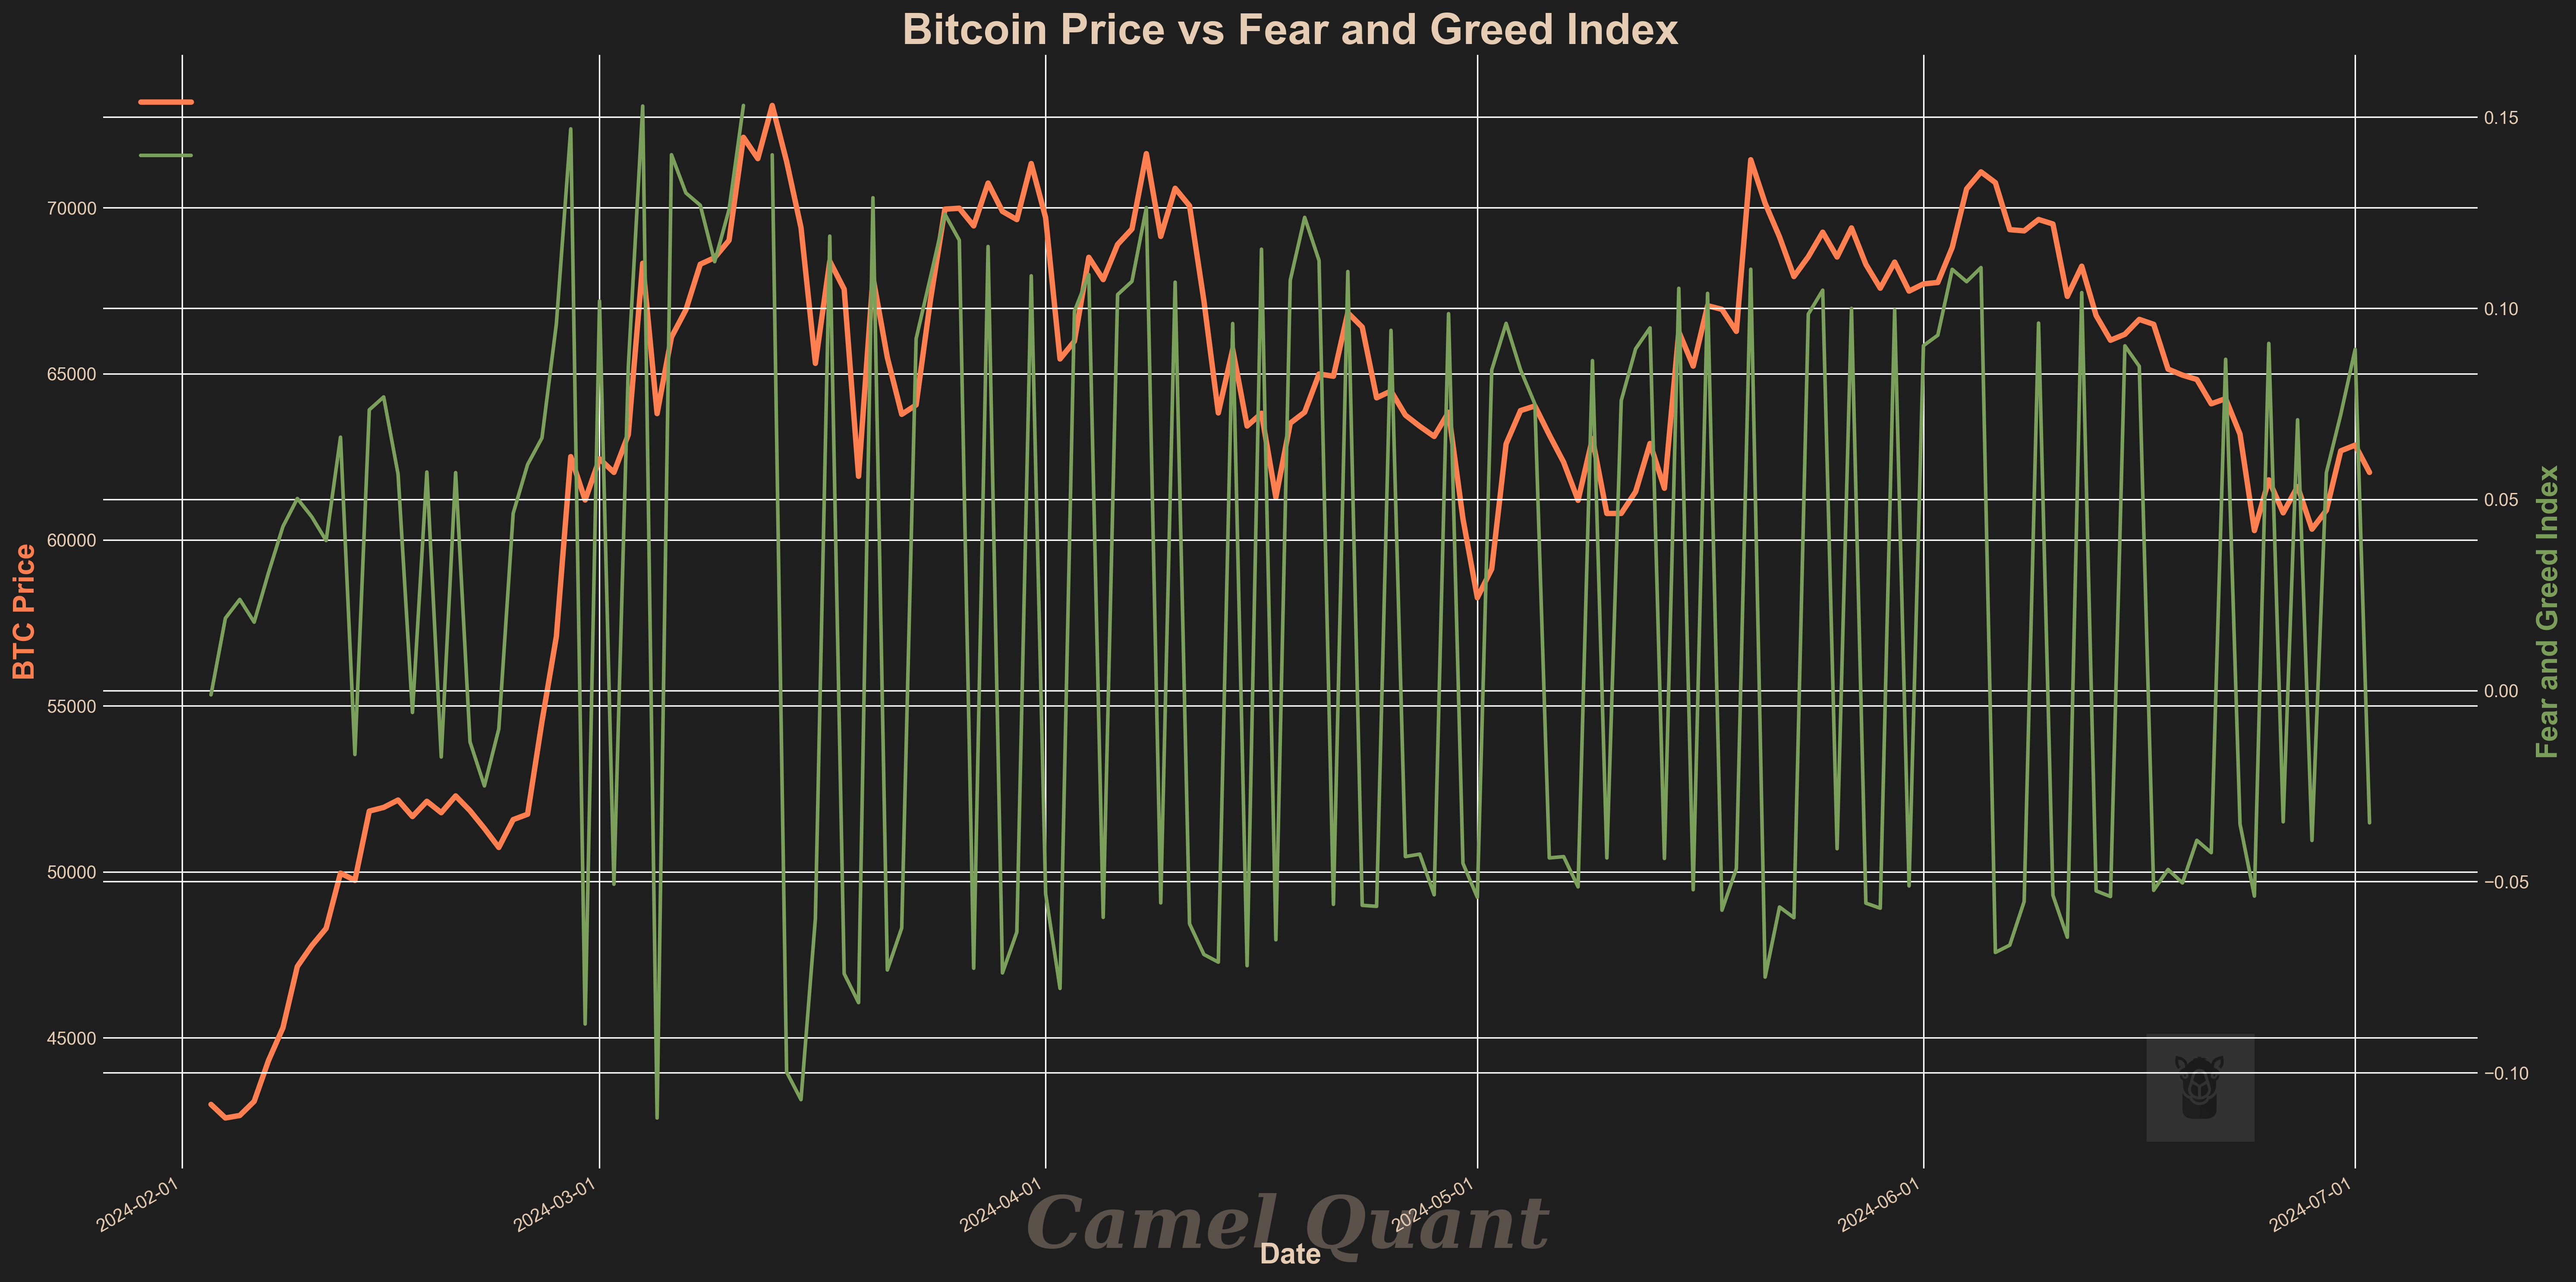

In [77]:
from sklearn.preprocessing import MinMaxScaler

btc_normal_graph = btc_all.copy()
btc_normal_graph = btc_normal_graph[['timeOpen', 'close', 'volume', 'marketCap', 'GTrends', 'weighted_sen', 'RSI', 'momentum']]
btc_normal_graph = btc_normal_graph[btc_normal_graph['timeOpen'] > '2024-02-02']


def calculate_fear_and_greed_index(data):
    scaler = MinMaxScaler()

    # Calculate price change
    data['price_change'] = data['close'].pct_change()

    # Normalize the data
    data['price_normalized'] = scaler.fit_transform(data[['close']])
    data['volume_normalized'] = scaler.fit_transform(data[['volume']])
    data['gtrends_normalized'] = scaler.fit_transform(data[['GTrends']])
    data['reddit_sentiment_normalized'] = scaler.fit_transform(data[['weighted_sen']])
    data['market_cap_normalized'] = scaler.fit_transform(data[['marketCap']])

    # Determine the fear and greed components
    data['price_component'] = data.apply(lambda row: row['price_normalized'] if row['price_change'] > 0 else -row['price_normalized'], axis=1)
    data['volume_component'] = data.apply(lambda row: row['volume_normalized'] if row['price_change'] > 0 else -row['volume_normalized'], axis=1)
    data['gtrends_component'] = data.apply(lambda row: row['gtrends_normalized'] if row['price_change'] > 0 else -row['gtrends_normalized'], axis=1)
    data['reddit_sentiment_component'] = data['reddit_sentiment_normalized']  # Direct sentiment normalization
    data['market_cap_component'] = data.apply(lambda row: row['market_cap_normalized'] if row['price_change'] > 0 else -row['market_cap_normalized'], axis=1)

    # Calculate Fear and Greed Index
    data['fear_and_greed_index'] = (
        data['price_component']*0.2 +
        data['volume_component']*0.2 +
        data['gtrends_component']*0.2 +
        data['reddit_sentiment_component']*0.2 +
        data['market_cap_component']*0.2
    ) / 5

    result = data[['timeOpen', 'close', 'volume', 'GTrends', 'weighted_sen', 'marketCap', 'fear_and_greed_index']]

    return result

btc_normal_graph = calculate_fear_and_greed_index(btc_normal_graph)

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import numpy as np


# Create the figure and axis
fig, ax1 = plt.subplots(figsize=(20, 10), dpi=300)
fig.patch.set_facecolor(desert_colors['night'])
ax1.set_facecolor(desert_colors['night'])

# Plot BTC price on the left y-axis
ax1.plot(btc_normal_graph['timeOpen'], btc_normal_graph['close'], label='BTC Price', color=desert_colors['sunset'], linewidth=3)
ax1.set_xlabel('Date', fontsize=16, fontweight='bold', color=desert_colors['sand'])
ax1.set_ylabel('BTC Price', fontsize=16, fontweight='bold', color=desert_colors['sunset'])
ax1.tick_params(axis='y', labelcolor=desert_colors['sunset'])

# Create a twin axis for the Fear and Greed Index
ax2 = ax1.twinx()

# Plot Fear and Greed Index on the right y-axis
ax2.plot(btc_normal_graph['timeOpen'], btc_normal_graph['fear_and_greed_index'], label='Fear and Greed Index', color=desert_colors['cactus'], linewidth=2)
ax2.set_ylabel('Fear and Greed Index', fontsize=16, fontweight='bold', color=desert_colors['cactus'])
ax2.tick_params(axis='y', labelcolor=desert_colors['cactus'])

# Set the title
plt.title('Bitcoin Price vs Fear and Greed Index', fontsize=24, fontweight='bold', color=desert_colors['sand'])

# Combine legends with improved visibility
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
legend = ax1.legend(lines1 + lines2, labels1 + labels2, 
                    loc='upper left', 
                    fontsize=14,
                    facecolor=desert_colors['light'],
                    edgecolor=desert_colors['dune'],
                    framealpha=0.8,
                    fancybox=True,
                    shadow=True,
                    borderpad=1,
                    labelspacing=1.2)

# Improve legend text color for better contrast
for text in legend.get_texts():
    text.set_color(desert_colors['night'])

# Format x-axis
plt.gcf().autofmt_xdate()  # Rotation
myFmt = mdates.DateFormatter('%Y-%m-%d')
ax1.xaxis.set_major_formatter(myFmt)

# Adjust layout
plt.tight_layout()

# Add watermark text
fig.text(0.5, 0.02, 'Camel Quant', fontsize=40, color=desert_colors['sand'], 
         ha='center', va='bottom', alpha=0.3, fontweight='bold', 
         fontfamily='serif', style='italic')

# Add camel silhouette as watermark
camel_img = plt.imread('tweet_outputs/camel.jpg')  # Replace with the path to your camel silhouette image
camel_img = np.mean(camel_img, axis=2)  # Convert to grayscale
imagebox = OffsetImage(camel_img, zoom=0.15, alpha=0.1)
ab = AnnotationBbox(imagebox, (0.85, 0.15), xycoords='figure fraction', frameon=False)
fig.add_artist(ab)

# Custom styling for all axes
for ax in [ax1, ax2]:
    ax.tick_params(colors=desert_colors['sand'], which='both')
    for spine in ax.spines.values():
        spine.set_edgecolor(desert_colors['sand'])

# Show the chart
plt.show()


